In [3]:
print("--- Environment ---")

import sys, pkg_resources
print("Python: " + sys.version)

for package in pkg_resources.working_set:
    print(package.key.ljust(20), package.version)

--- Environment ---
Python: 3.8.8 (default, Feb 19 2021, 16:53:21) [GCC]
tornado              6.1
tensorflow           2.4.1
scipy                1.6.2
pyzmq                22.0.3
protobuf             3.15.8
pillow               8.2.0
numpy                1.19.5
matplotlib           3.4.1
kiwisolver           1.3.1
h5py                 2.10.0
grpcio               1.32.0
wrapt                1.12.1
wheel                0.36.2
werkzeug             1.0.1
wcwidth              0.2.5
urllib3              1.26.4
typing-extensions    3.7.4.3
traitlets            5.0.5
termcolor            1.1.0
tensorflow-estimator 2.4.0
tensorboard          2.5.0
tensorboard-plugin-wit 1.8.0
tensorboard-data-server 0.6.0
six                  1.15.0
setuptools           56.0.0
rsa                  4.7.2
requests             2.25.1
requests-oauthlib    1.3.0
python-dateutil      2.8.1
pyparsing            2.4.7
pygments             2.8.1
pyasn1               0.4.8
pyasn1-modules       0.2.8
ptyprocess          

In [4]:
import pathlib
from scipy.io import loadmat

data = loadmat(str(pathlib.Path().absolute()) + '/mnist/data.mat')
data_test = loadmat(str(pathlib.Path().absolute()) + '/mnist/test.mat')

X_ = data['X']
S_ = data['S']

X_t = data_test['Xt']
S_t = data_test['St']

In [5]:
print("Shape of X: ".ljust(20),  X_.shape)
print("Shape of S: ".ljust(20),  S_.shape)

print("Shape of X_t: ".ljust(20),  X_t.shape)
print("Shape of S_t: ".ljust(20),  S_t.shape)

Shape of X:          (60000, 784)
Shape of S:          (60000, 10)
Shape of X_t:        (10000, 784)
Shape of S_t:        (10000, 10)


In [6]:
from matplotlib import pyplot as plt
import numpy as np

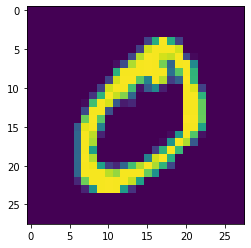

0


In [7]:
def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + (27 - j)]

    pixels = pixels.reshape((28, 28))
    pixels = np.rot90(pixels)
    plt.imshow(pixels, cmap='viridis')
    plt.show()

def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    if class_ == 10:
        return 0
    else:
        return class_ 
        
for i in range(15):
    if S_[i][9] == 1:
        display_sample(X_[i])
        print(get_class_from_sample(S_[i]))

# print(S[100])

In [40]:
partition = 0.9

# Creation os a random sequence of indexes
index = np.arange(0,X_.shape[0])
np.random.shuffle(index)

training_set_size = int(X_.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X_[index_training]
S_training = S_[index_training]

X_validation = X_[index_validation]
S_validation = S_[index_validation]

# ELM X
# We ew concatenate a column of 1's to account for the V0 of each neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)
X_t_elm = np.concatenate((np.transpose(np.array([np.ones(X_t.shape[0])])), X_t), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("S_training:".ljust(20), S_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("S_validation:".ljust(20), S_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (54000, 784)
S_training:          (54000, 10)
X_validation:        (6000, 784)
S_validation:        (6000, 10)
X_training_elm:      (54000, 785)
X_validation_elm:    (6000, 785)


In [9]:

def leaky_relu(table):
     return np.where(table > 0, table,  0.02 * table)

def relu(table):
     return np.where(table > 0, table,  0)

def get_h(X, V, activation_function): 
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, S, c): 
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), S)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w


In [10]:
def get_rates_from_c_values(X, S, c_values, Ws = []):
    hit_rates = []
    
    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)
        
        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, S, c)
            Ws.append(W)

        S_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(S_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == 10:
                estimated_class = 0
            if estimated_class == get_class_from_sample(S[index]):
                hits += 1
        hit_rates.append(hits/S_estimate.shape[0])
    return hit_rates, Ws

In [55]:
c_values = [pow(2,d) for d in range(-10, 18, 2)]

hit_rates_training, Ws = get_rates_from_c_values(X_training, S_training, c_values)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536


In [56]:
hit_rates_validation, _ = get_rates_from_c_values(X_validation, S_validation, c_values, Ws)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536


Best c value: 1024 
Performance of this vaule: 0.8495833333333334


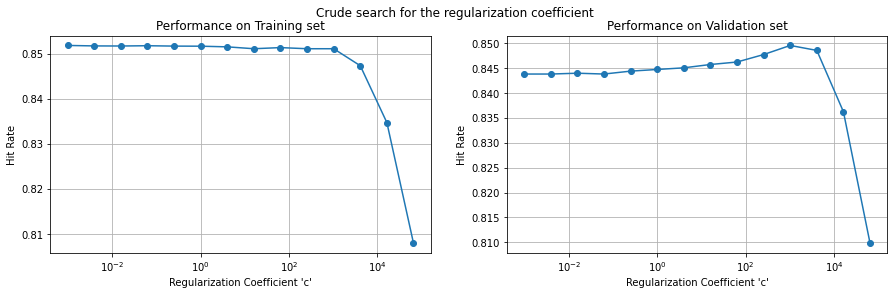

In [57]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation[best_c_index]))



In [58]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = range(int(best_c/4), int(4*best_c), int(step))

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(X_training, S_training, fine_c_values)

256
640
1024
1408
1792
2176
2560
2944
3328
3712


In [59]:
hit_rates_validation_fine, _ = get_rates_from_c_values(X_validation, S_validation, fine_c_values, Ws_fine)

256
640
1024
1408
1792
2176
2560
2944
3328
3712


Best c value: 1792 
Performance of this vaule: 0.8500833333333333


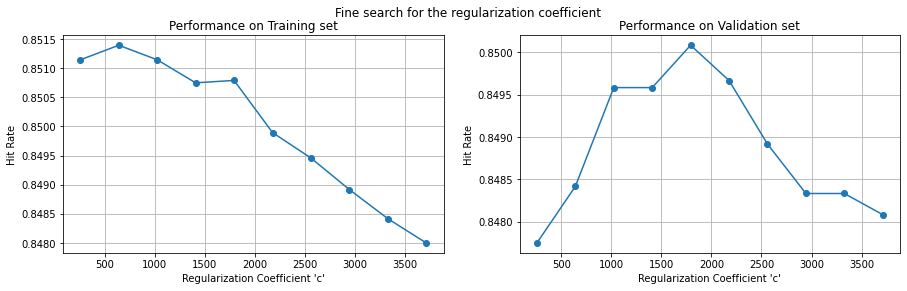

In [60]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [61]:
W = get_w(X_, S_, best_c)

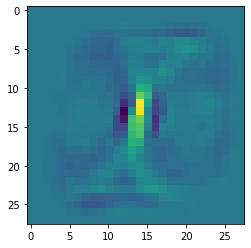

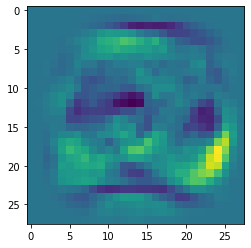

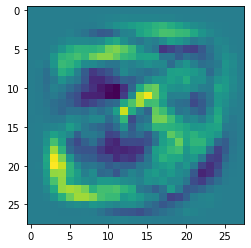

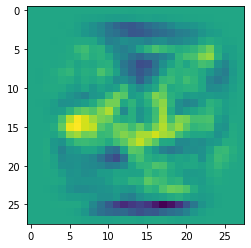

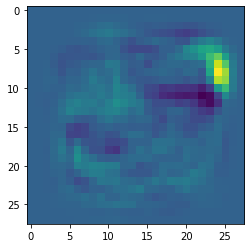

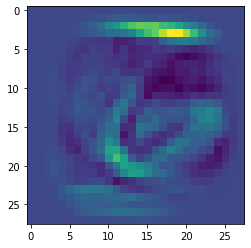

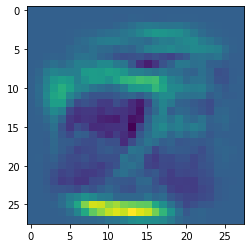

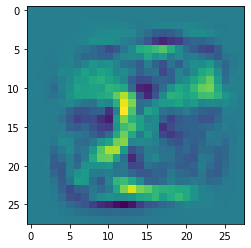

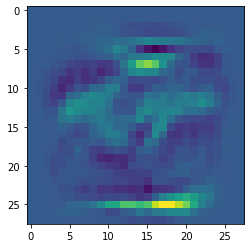

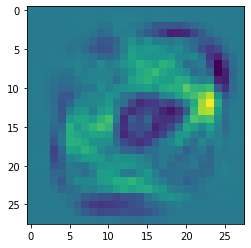

In [62]:
for classifier in np.transpose(W):
    display_sample(classifier)

In [63]:
S_t_estimate = np.matmul(X_t,W)

hits = 0
confusion_matrix = np.zeros((10, 10), dtype=int)

# ja_foi = []

for index, estimate in enumerate(S_t_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == 10:
        estimated_class = 0
    if estimated_class == get_class_from_sample(S_t[index]):
        hits += 1
        confusion_matrix[estimated_class][estimated_class] += 1
    else:
        confusion_matrix[estimated_class][get_class_from_sample(S_t[index])] += 1
        # parte para colher exemplos de classificacoes equivocadas
        # if not(get_class_from_sample(S_t[index]) in ja_foi):
        #     print(index, estimated_class, get_class_from_sample(S_t[index]))
        #     display_sample(X_t[index])
        #     ja_foi.append(get_class_from_sample(S_t[index]))
        # if len(ja_foi) >= 4:
        #     break

print("Performance on test set: {}".format(hits/S_t_estimate.shape[0]))


Performance on test set: 0.8573


In [64]:
print(confusion_matrix)

# condition positive (P) per class
P = np.zeros(10, dtype=int)

# condition negative (N) per class
N = np.zeros(10, dtype=int)

# true positive (TP) per class
TP = np.zeros(10, dtype=int)

# true negative (TN) per class
TN = np.zeros(10, dtype=int)

# false positive (FP) per class *******
FP = np.zeros(10, dtype=int)

# false negative (FN) per class *******
FN = np.zeros(10, dtype=int)

sum_along_lines = np.sum(confusion_matrix, 1)
sum_along_columns = np.sum(confusion_matrix, 0)

for sample in S_t:
    real_class = get_class_from_sample(sample)

    # P
    P[real_class] += 1

    # N
    for i in range(10):
        if i != real_class:
            N[i] += 1

for i in range(10):
    # TP
    TP[i] = confusion_matrix[i][i]

    # TN
    for j in range(10):
        if (j != i):
            TN[i] += confusion_matrix[j][j]

    # FP
    FP[i] = sum_along_lines[i] - confusion_matrix[i][i]
    FN[i] = sum_along_columns[i] - confusion_matrix[i][i]


# sensitivity, recall, hit rate, or true positive rate (TPR) per class
TPR = TP/P

# specificity, selectivity or true negative rate (TNR) per class
TNR = TN/N

# precision or positive predictive value (PPV) per class
PPV = TP / (TP + FP)

# negative predictive value (NPV) per class
NPV = TN / (TN + FN)

# miss rate or false negative rate (FNR) per class
FNR = FN / P

print("P:", P)
print("N:", N)
print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)
print("TPR:", TPR)
print("TNR:", TNR)
print("PPV:", PPV)
print("NPV:", NPV)
print("FNR:", FNR)


[[ 942    0   18    5    1   19   15    5   13   22]
 [   0 1104   61   14   24   15   10   44   62   14]
 [   1    2  822   24    6    8    6   17    7    3]
 [   2    2   22  886    2   96    0    7   31   13]
 [   1    1   16    3  876   23   16   16   23   62]
 [   7    0    0   13    1  591   15    0   28    1]
 [  18    5   24   11   11   25  888    2   19    2]
 [   1    2   24   28    1   20    0  889   17   62]
 [   7   19   42   17   11   72    8    2  754    9]
 [   1    0    3    9   49   23    0   46   20  821]]
P: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
N: [9020 8865 8968 8990 9018 9108 9042 8972 9026 8991]
TP: [ 942 1104  822  886  876  591  888  889  754  821]
TN: [7631 7469 7751 7687 7697 7982 7685 7684 7819 7752]
FP: [ 98 244  74 175 161  65 117 155 187 151]
FN: [ 38  31 210 124 106 301  70 139 220 188]
TPR: [0.96122449 0.97268722 0.79651163 0.87722772 0.89205703 0.66255605
 0.92693111 0.86478599 0.77412731 0.81367691]
TNR: [0.84600887 0.84252679 0.8642952

MNIST ELM

In [41]:
sigma = 0.2
mu = 0
# 784 wieghts from X input and 1 from bias input V0
V  = sigma * np.random.randn(785, 1000) + mu

In [42]:
c_values = [pow(2,d) for d in range(-10, 18, 2)]

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), S_training, c_values)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536


In [44]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), S_validation, c_values, Ws)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536


Best c value: 0.0009765625 
Performance of this vaule: 0.9392


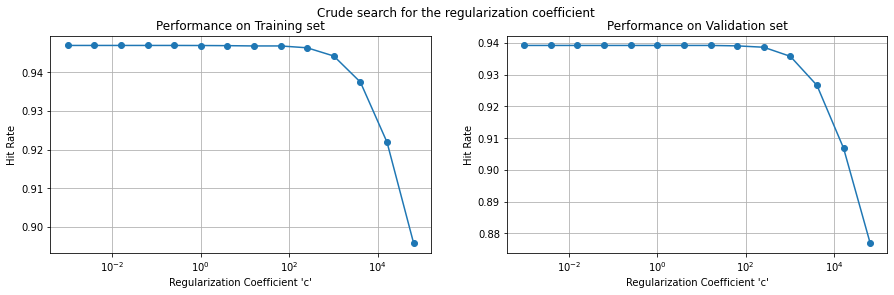

In [43]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation[best_c_index]))

In [25]:
step =  0.1 * (4* best_c - best_c / 4);

fine_c_values = np.arange(best_c/4, 4*best_c, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), S_training, fine_c_values)

16.0
40.0
64.0
88.0
112.0
136.0
160.0
184.0
208.0
232.0


In [26]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), S_validation, fine_c_values, Ws_fine)

16.0
40.0
64.0
88.0
112.0
136.0
160.0
184.0
208.0
232.0


Best c value: 64.0 
Performance of this vaule: 0.9629166666666666


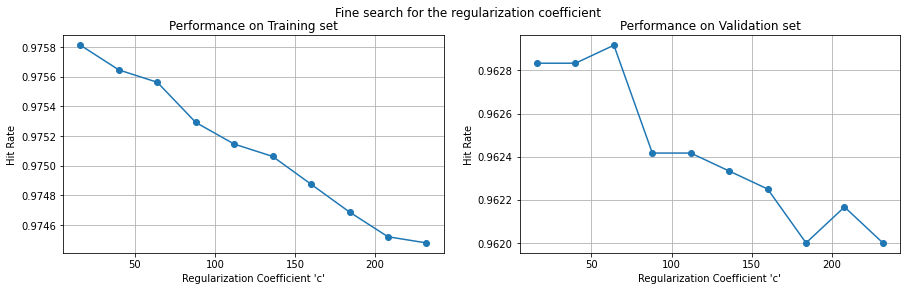

In [27]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [28]:
W_elm = get_w(get_h(X_training_elm, V, relu), S_training, best_c)

In [29]:
S_t_estimate = np.matmul(get_h(X_t_elm, V, relu), W_elm)

hits = 0
confusion_matrix = np.zeros((10, 10), dtype=int)

# ja_foi = []

for index, estimate in enumerate(S_t_estimate):
    # print(index)
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == 10:
        estimated_class = 0
    if estimated_class == get_class_from_sample(S_t[index]):
        hits += 1
        confusion_matrix[estimated_class][estimated_class] += 1
    else:
        confusion_matrix[estimated_class][get_class_from_sample(S_t[index])] += 1
        # parte para colher exemplos de classificacoes equivocadas
        # if not(get_class_from_sample(S_t[index]) in ja_foi):
        #     print(index, estimated_class, get_class_from_sample(S_t[index]))
        #     display_sample(X_t[index])
        #     ja_foi.append(get_class_from_sample(S_t[index]))
        # if len(ja_foi) >= 4:
        #     break

print("Performance on test set: {}".format(hits/S_t_estimate.shape[0]))


Performance on test set: 0.9654


In [30]:
print(confusion_matrix)

# condition positive (P) per class
P = np.zeros(10, dtype=int)

# condition negative (N) per class
N = np.zeros(10, dtype=int)

# true positive (TP) per class
TP = np.zeros(10, dtype=int)

# true negative (TN) per class
TN = np.zeros(10, dtype=int)

# false positive (FP) per class *******
FP = np.zeros(10, dtype=int)

# false negative (FN) per class *******
FN = np.zeros(10, dtype=int)

sum_along_lines = np.sum(confusion_matrix, 1)
sum_along_columns = np.sum(confusion_matrix, 0)

for sample in S_t:
    real_class = get_class_from_sample(sample)

    # P
    P[real_class] += 1

    # N
    for i in range(10):
        if i != real_class:
            N[i] += 1

for i in range(10):
    # TP
    TP[i] = confusion_matrix[i][i]

    # TN
    for j in range(10):
        if (j != i):
            TN[i] += confusion_matrix[j][j]

    # FP
    FP[i] = sum_along_lines[i] - confusion_matrix[i][i]
    FN[i] = sum_along_columns[i] - confusion_matrix[i][i]


# sensitivity, recall, hit rate, or true positive rate (TPR) per class
TPR = TP/P

# specificity, selectivity or true negative rate (TNR) per class
TNR = TN/N

# precision or positive predictive value (PPV) per class
PPV = TP / (TP + FP)

# negative predictive value (NPV) per class
NPV = TN / (TN + FN)

# miss rate or false negative rate (FNR) per class
FNR = FN / P

print("P:", P)
print("N:", N)
print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)
print("TPR:", TPR)
print("TNR:", TNR)
print("PPV:", PPV)
print("NPV:", NPV)
print("FNR:", FNR)


[[ 966    0    5    1    2    3    5    3    8    4]
 [   0 1122    0    0    2    1    3    8    2    6]
 [   2    3  986    5    3    0    0   20    3    2]
 [   1    2    8  978    0    9    1    2    7   11]
 [   0    1    3    1  943    0    4    3    6   12]
 [   0    1    1    8    0  863    5    0    4    7]
 [   4    3    3    0    6    9  940    0    4    3]
 [   2    0   11    8    0    2    0  973    4    8]
 [   4    3   15    5    3    4    0    2  931    4]
 [   1    0    0    4   23    1    0   17    5  952]]
P: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
N: [9020 8865 8968 8990 9018 9108 9042 8972 9026 8991]
TP: [ 966 1122  986  978  943  863  940  973  931  952]
TN: [8688 8532 8668 8676 8711 8791 8714 8681 8723 8702]
FP: [31 22 38 41 30 26 32 35 40 51]
FN: [14 13 46 32 39 29 18 55 43 57]
TPR: [0.98571429 0.98854626 0.95542636 0.96831683 0.96028513 0.96748879
 0.98121086 0.94649805 0.95585216 0.94350842]
TNR: [0.9631929  0.96243655 0.96654773 0.9650723  0.96595